In [115]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
import umap
import GPy
import seaborn as sns
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

In [95]:
x = np.zeros((1440, 16384))
y = np.zeros(1440)
for i in range(20):
    for j in range(72):
        x[i*72 + j] = mpimg.imread(f'data/coil-20-proc/obj{i+1}__{j}.png').flatten()
        y[i*72 + j] = i

In [96]:
def visualize(z_pred, method):
    for i in range(20):
        idx = y == i
        plt.plot(z_pred[idx, 0], z_pred[idx, 1], '.', label=f'{i}')
    plt.legend()
    plt.title(f'{method}')
    
d_latent = 2

0.6416666666666667

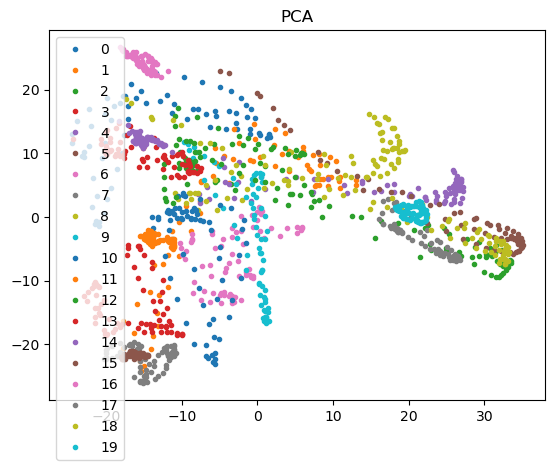

In [97]:
z_pca = PCA(n_components=d_latent).fit_transform(x)
visualize(z_pca, 'PCA')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_pca, y, cv=5)
scores.mean()

0.5993055555555556

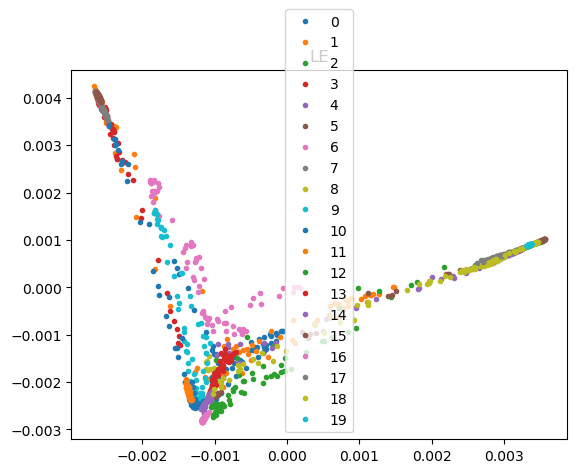

In [30]:
z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x)
visualize(z_le, 'LE')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_le, y, cv=5)
scores.mean()

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


0.923611111111111

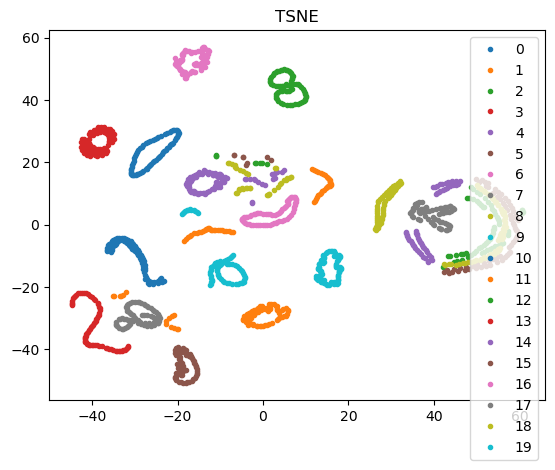

In [31]:
z_tsne = TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x)
visualize(z_tsne, 'TSNE')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_tsne, y, cv=5)
scores.mean()

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning:The number of connected components of the neighbors graph is 9 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /storage/home/hcoda1/1/cli726/.conda/envs

0.5694444444444445

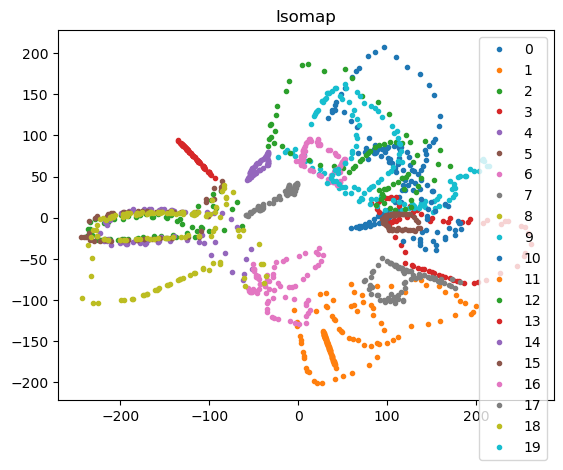

In [123]:
z_isomap = Isomap(n_components=d_latent).fit_transform(x)
visualize(z_isomap, 'Isomap')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_isomap, y, cv=5)
scores.mean()

0.8756944444444444

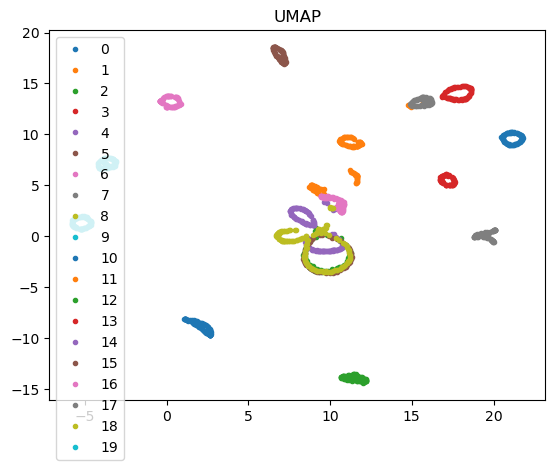

In [33]:
z_umap = umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x)
visualize(z_umap, 'UMAP')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_umap, y, cv=5)
scores.mean()

In [108]:
def check_connectivity(d):
    n_points = d.shape[0]
    sub_graph_list = []
    existing_indices = np.arange(n_points)
    existing_d = d.copy()
    while True:
        idx = np.isinf(existing_d[0])
        sub_graph = existing_indices[~idx]
        sub_graph_list.append(sub_graph)
        existing_indices = existing_indices[idx]
        existing_d = existing_d[idx][:, idx]
        if len(existing_indices) == 0:
            return sub_graph_list

In [114]:
check_connectivity(d)[2]

array([720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745,
       746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758,
       759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771,
       772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784,
       785, 786, 787, 788, 789, 790, 791])

In [86]:
def grid_point(d_latent, side_length, n):
    coordinate = []
    while True:
        quotient = n // side_length
        remainder = n % side_length
        coordinate.append(remainder)
        if quotient == 0:
            break
        n = quotient
    coordinate.reverse()
    return np.hstack((np.zeros(d_latent - len(coordinate)), coordinate))

0.9194444444444445

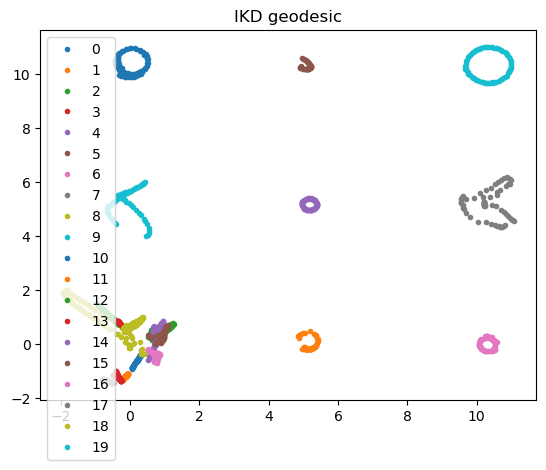

In [124]:
z_ikd = core.ikd_geodesic(x, d_latent, ref_point='center')
visualize(z_ikd, 'IKD geodesic')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_ikd, y, cv=5)
scores.mean()

0.9597222222222221

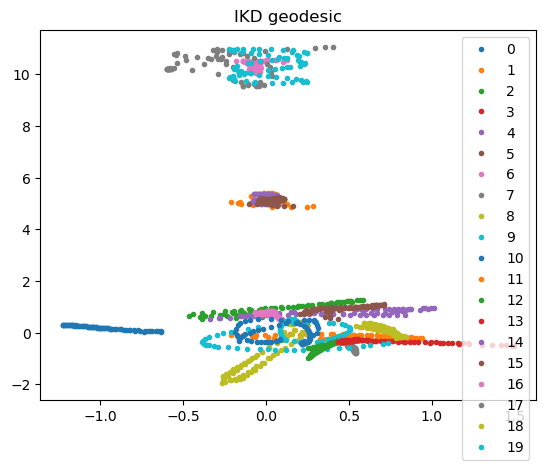

In [125]:
z_ikd = core.ikd_geodesic(x, 3, ref_point='center')
visualize(z_ikd, 'IKD geodesic')
clf = KNeighborsClassifier()
scores = cross_val_score(clf, z_ikd, y, cv=5)
scores.mean()

Text(0.5, 0.92, 'IKD geodesic')

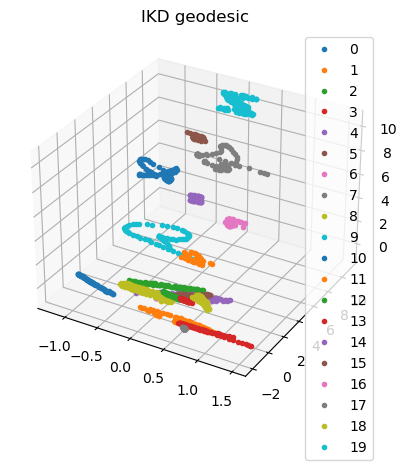

In [128]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(20):
    idx = y == i
    plt.plot(z_ikd[idx, 0], z_ikd[idx, 1], z_ikd[idx, 2], '.', label=f'{i}')
plt.legend()
plt.title(f'IKD geodesic')